# Predicting Diatom concentration with functional regression based on the oceanographic boxes (spatial means)

## Importing

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import r_regression

from skfda.representation.grid import FDataGrid
from skfda.ml.clustering import KMeans

from skfda.misc.hat_matrix import LocalLinearRegressionHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother

from skfda.ml.regression import HistoricalLinearRegression

from sklearn.metrics import root_mean_squared_error as rmse

import os
import lzma
import dill

from tqdm import tqdm

import cmocean.cm as cm
import salishsea_tools.viz_tools as sa_vi


## Datasets Preparation

In [ ]:
# Creation of the training - testing datasets

def datasets_preparation(dataset, boxes, regions, name, inputs_names):
    
    targets = dataset[name].to_numpy().reshape(*dataset[name].to_numpy().shape[:1],-1)

    inputs = []
    for i in inputs_names:
        inputs.append(dataset[i].to_numpy().reshape(*dataset[i].to_numpy().shape[:1],-1))
    inputs = np.array(inputs)

    # Splitting in years
    inputs = np.array(np.split(inputs,len(np.unique(dataset.time_counter.dt.year)),axis=1))
    targets = np.array(np.split(targets,len(np.unique(dataset.time_counter.dt.year)),axis=0))

    # Transposing
    inputs = np.transpose(inputs, (1,2,0,3))
    targets = np.transpose(targets, (1,0,2))

    indx = np.where(~np.isnan(targets[0]).any(axis=0))
    inputs = inputs[:,:,:,indx[0]]
    targets = targets[:,:,indx[0]]

    regions = np.ravel(regions)
    regions = regions[indx[0]]

    regions_indiv_t = np.zeros((len(np.unique(dataset.time_counter.dt.dayofyear))-1,len(np.unique(dataset.time_counter.dt.year)),len(boxes)))
    regions_indiv_d = np.zeros((len(inputs_names),len(np.unique(dataset.time_counter.dt.dayofyear))-1,len(np.unique(dataset.time_counter.dt.year)),len(boxes)))

    for j in range (0,len(boxes)):

        regions_indiv_d[:,:,:,j] = np.nanmean(np.where(regions==j, inputs, np.nan),axis=3)
        regions_indiv_t[:,:,j] = np.nanmean(np.where(regions==j, targets, np.nan),axis=2)

    inputs = regions_indiv_d
    targets = regions_indiv_t

    return(inputs, targets)


## File Creation

In [ ]:
def file_creation(path, variable, name):

    temp = variable.to_dataset(name=name)
    temp.to_netcdf(path = path + 'targets_predictions.nc', mode='a', encoding={name:{"zlib": True, "complevel": 9}})
    temp.close()
    

## Regressor

In [ ]:
def regressor (inputs, targets, j, r_inputs, n_intervals, lag, indx):

    # Printing of the correlation coefficients
    temp_inputs = np.reshape(inputs,(len(inputs),inputs.shape[1]*inputs.shape[2]), order='F')
    temp_inputs = temp_inputs.transpose()
    temp_targets = np.reshape(targets, (targets.shape[0]*targets.shape[1]), order='F')

    r_inputs[j,indx] = np.round(r_regression(temp_inputs,temp_targets),2)

    # Scaling the inputs
    scaler_inputs = make_column_transformer((StandardScaler(), np.arange(0,len(inputs))))
    temp_inputs = scaler_inputs.fit_transform(temp_inputs)
    temp_inputs = temp_inputs.transpose()
    inputs = np.reshape(temp_inputs,(len(inputs),inputs.shape[1],inputs.shape[2]), order='F')   
    
    # Scaling the targets
    scaler_targets = StandardScaler()
    temp_targets = np.expand_dims(temp_targets,-1)
    temp_targets = scaler_targets.fit_transform(temp_targets)
    targets = temp_targets.reshape(targets.shape, order='F')

    # Final transformations
    inputs = np.transpose(inputs,axes=(2,1,0))
    targets = targets.transpose()
    inputs = FDataGrid(data_matrix=inputs, grid_points=np.arange(0,len(targets[0])))
    targets = FDataGrid(data_matrix=targets, grid_points=np.arange(0,len(targets[0])))

    # Smoothing
    # targets = targets.to_basis(FourierBasis(n_basis=10))
    kernel_estimator = LocalLinearRegressionHatMatrix(bandwidth=1)
    smoother = KernelSmoother(kernel_estimator=kernel_estimator)
    inputs = smoother.fit_transform(inputs)

    model = HistoricalLinearRegression(n_intervals=n_intervals, lag=lag)
    regr = model.fit(inputs,targets)

    return(regr,scaler_inputs,scaler_targets,smoother,r_inputs)


## Scaling

In [ ]:
def scaling(regr,inputs,scaler_inputs,targets,scaler_targets,smoother):

    # Scaling the inputs
    temp = np.reshape(inputs,(len(inputs),inputs.shape[1]*inputs.shape[2]), order='F')
    temp = temp.transpose()
    temp = scaler_inputs.transform(temp)
    temp = temp.transpose()        
    inputs = np.reshape(temp,(len(inputs),inputs.shape[1],inputs.shape[2]), order='F')
        
    inputs = np.transpose(inputs,axes=(2,1,0))
    inputs = FDataGrid(data_matrix=inputs, grid_points=np.arange(0,len(targets)))

    inputs = smoother.transform(inputs)

    predictions = regr.predict(inputs)

    # Post-processing of predictions
    predictions = np.array(predictions.to_grid(np.arange(0,len(targets))).data_matrix)
    predictions = np.squeeze(predictions,2)

    # Scaling the predictions
    temp = np.reshape(predictions, (targets.shape[0]*targets.shape[1]), order='F')
    temp = np.expand_dims(temp,axis=-1)
    temp = scaler_targets.inverse_transform(temp)
    predictions = temp.reshape(predictions.shape, order='F')
    predictions = predictions.transpose()

    return(predictions)


## Scatter Plot

In [ ]:
def scatter_plot(dates,targets, predictions, name):

    indx = pd.DatetimeIndex(dates[0:75]) # From the first year

    # compute slope m and intercept b
    m, b = np.polyfit(targets, predictions, deg=1)

    fig, ax = plt.subplots()

    scatter = ax.scatter(targets,predictions, s = 10, c= indx.month)

    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()])]

    # plot fitted y = m*x + b
    ax.axline(xy1=(0, b), slope=m, color='r')

    ax.set_xlabel('targets')
    ax.set_ylabel('predictions')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')
    ax.legend(handles=scatter.legend_elements()[0], labels=['February','March','April'])

    ax.plot(lims, lims,linestyle = '--',color = 'k')

    fig.suptitle(name)

    plt.show()

    return(m)

## Plotting (Mean Values)

In [ ]:
def plotting_mean_values(dates,boxes,targets,predictions,r_train,rms_train,slope_train,category,units,region,boxnames,period,labels):

    years = np.unique(dates.year)

    targets = np.reshape(targets,(targets.shape[0]*targets.shape[1],targets.shape[2]), order = 'F')
    predictions = np.reshape(predictions,(predictions.shape[0]*predictions.shape[1],predictions.shape[2]), order = 'F')
    
    targets_masked = np.ma.array(targets)
    predictions_masked = np.ma.array(predictions)

    for year in years:
        targets_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        predictions_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked

    for i in range (0,len(boxes)):

        temp = pd.DataFrame(np.vstack((r_train[i],rms_train[i],slope_train[i])).transpose(),index=[boxnames[i]],columns=['r','rms [%]','slope'])
        display(temp)

        fig, ax = plt.subplots(figsize=(19,5))

        ax.plot(targets_masked[:,i], label = 'targets')
        ax.plot(predictions_masked[:,i], label = 'predictions')
        
        ticks = np.arange(0,len(years)*len(labels),len(labels)/2)
        ticks = np.int16(ticks)
        labels2 = np.tile(labels,len(years))

        ax.set_xticks(ticks, labels2[ticks])

        ax2 = ax.secondary_xaxis('bottom')
        ax2.set_xticks(ticks=np.arange(0,len(years)*len(labels),len(labels)), labels=years)
        
        ax2.tick_params(length=0, pad=30)
        plt.suptitle('Mean Diatom '+category + ' ' +units + ' ' + period + ' ' + region + ' ' + boxnames[i])
        plt.legend()

        plt.show()


## Plotting (Paper)

In [ ]:
def plotting_paper(dates,targets,predictions,units,boxnames,period,labels,season,r_train,r_train_season,r_test,r_test_season,rms_train,rms_test):

    years = np.unique(dates.year)

    targets = np.reshape(targets,(targets.shape[0]*targets.shape[1],targets.shape[2]), order = 'F')
    predictions = np.reshape(predictions,(predictions.shape[0]*predictions.shape[1],predictions.shape[2]), order = 'F')
    
    targets_masked = np.ma.array(targets)
    predictions_masked = np.ma.array(predictions)

    for year in years:
        targets_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        predictions_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked

    names = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']

    k,l = 0,0
    fig, ax = plt.subplots(4, 3, figsize=(17, 15), layout='constrained')

    ticks = np.arange(0,len(years)*len(labels),len(labels)/2)
    ticks = np.int16(ticks)
    labels2 = np.tile(labels,len(years))

    test = np.arange(0,len(targets_masked))

    for j in np.arange (0,len(boxnames)):
        
        ax[k, l].plot(targets_masked[:,j])
        ax[k, l].plot(test[:ticks[-2]-1],predictions_masked[0:ticks[-2]-1,j])
        ax[k, l].plot(test[ticks[-2]:],predictions_masked[ticks[-2]:,j], color = 'tab:red')
        ax[k,l].fill_between((test[0],test[ticks[2]-2]), np.max((targets_masked[:,j],predictions_masked[:,j])), np.min((targets_masked[:,j],predictions_masked[:,j])), alpha=0.3, color='grey')
        ax[k,l].fill_between((test[ticks[4]-1],test[ticks[6]-2]), np.max((targets_masked[:,j],predictions_masked[:,j])), np.min((targets_masked[:,j],predictions_masked[:,j])), alpha=0.3, color='grey')
        ax[k,l].fill_between((test[ticks[-2]-1],test[-1]), np.max((targets_masked[:,j],predictions_masked[:,j])), np.min((targets_masked[:,j],predictions_masked[:,j])), alpha=0.3, color='grey')

        ax[k, l].set_title(boxnames[j])
        
        ax[k,l].annotate(names[j], (0.02, 0.9), xycoords='axes fraction', fontsize=14)

        ax[k,l].set_xticks(ticks, labels2[ticks], rotation=20)

        ax2 = ax[k, l].secondary_xaxis('bottom')
        ax2.set_xticks(ticks=np.arange(0,len(years)*len(labels),len(labels)), labels=years)
        ax2.tick_params(length=0, pad=30)

        if l == 0:
            ax[k, l].set_ylabel(units + ' (no seasonality)')

        l=l+1
        if l==3:
            l=0
            k=k+1

    fig.legend(['targets', 'predictions', '2025'], ncols=3)
    fig.suptitle('Mean DB' + ' ' + period)

    ax[k, l].plot(season)
    ax[k, l].set_xticks(ticks=np.arange(0,len(labels),len(labels)//8+1), labels=labels[np.arange(0,len(labels),len(labels)//8+1)])
    ax[k, l].set_title('Long-term seasonalities (2007-2020)')
    ax[k, l].set_ylabel(units)
    ax[k, l].legend(boxnames)
    ax[k,l].annotate('(j)', (0.95, 0.05), xycoords='axes fraction', fontsize=14)

    l = l + 1
    ax[k, l].plot(r_train, label = 'R training', marker = '.', ls = ' ', markersize=12)
    ax[k, l].plot(r_test[0], label = 'R evaluation', marker = '.', ls = ' ', markersize=12)
    ax[k, l].plot(r_test[1], label = 'R testing', marker = '.', ls = ' ', markersize=12)
    ax[k, l].plot(r_train_season, label = 'R training (no seasonality)', marker = '.', ls = ' ', markersize=12)
    ax[k, l].plot(r_test_season[0], label = 'R evaluation (no seasonality)', marker = '.', ls = '', markersize=12)
    ax[k, l].plot(r_test_season[1], label = 'R testing (no seasonality)', marker = '.', ls = '', markersize=12)
    ax[k, l].set_xticks(ticks = np.arange(0, len(boxnames)), labels=boxnames)
    ax[k, l].set_title('Correlation coefficients')
    ax[k, l].legend(ncols=2)
    ax[k,l].annotate('(k)', (0.94, 0.15), xycoords='axes fraction', fontsize=14)
    ax[k, l].set_xlabel('Sub-regions')

    l = l + 1
    ax[k, l].plot(rms_train, label = 'RMSE training', marker = '.', ls = ' ', markersize=12)
    ax[k, l].plot(rms_test[0], label = 'RMSE evaluation', marker = '.', ls = ' ', markersize=12)
    ax[k, l].plot(rms_test[1], label = 'RMSE testing', marker = '.', ls = ' ', markersize=12)
    ax[k, l].set_xticks(ticks = np.arange(0, len(boxnames)), labels=boxnames)
    ax[k, l].set_ylabel('[%]')
    ax[k, l].set_title('Root mean square errors')
    ax[k, l].legend()
    ax[k,l].annotate('(l)', (0.95, 0.05), xycoords='axes fraction', fontsize=14)
    ax[k, l].set_xlabel('Sub-regions')



## Plotting (Mean Peaks)

In [ ]:
def plotting_mean_peaks(dates,boxes,targets,predictions,category,units,region,boxnames,period,labels):

    years = np.unique(dates.year)

    targets = np.reshape(targets,(targets.shape[0]*targets.shape[1],targets.shape[2]), order = 'F')
    predictions = np.reshape(predictions,(predictions.shape[0]*predictions.shape[1],predictions.shape[2]), order = 'F')
    
    targets_masked = np.ma.array(targets)
    predictions_masked = np.ma.array(predictions)

    for year in years:
      
        targets_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        predictions_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked

    for i in range (0,len(boxes)):

        fig, ax = plt.subplots(figsize=(19,5))

        ax.plot(targets_masked[:,i], label = 'targets')
        ax.plot(predictions_masked[:,i], label = 'predictions')
        
        ticks = np.arange(0,len(years)*len(labels),len(labels)/2)
        ticks = np.int16(ticks)
        labels2 = np.tile(labels,len(years))

        ax.set_xticks(ticks, labels2[ticks])

        ax2 = ax.secondary_xaxis('bottom')
        ax2.set_xticks(ticks=np.arange(0,len(years)*len(labels),len(labels)), labels=years)
        
        ax2.tick_params(length=0, pad=30)
        plt.suptitle('Mean Diatom '+category + ' ' +units + ' ' + period +  ' ' + region + ' ' + boxnames[i])
        plt.legend()

        plt.show()


## Plotting (Mean Inputs)

In [ ]:
def plotting_mean_inputs(dates,boxes,inputs,targets,inputs_names,name,boxnames, period, indexes, labels):

    years = np.unique(dates.year)

    inputs = np.reshape(inputs,(len(inputs), inputs.shape[1]*inputs.shape[2], inputs.shape[3]), order='F')
    targets = np.reshape(targets,(targets.shape[0]*targets.shape[1],targets.shape[2]), order = 'F')

    ticks = np.arange(0,len(years)*len(labels),len(labels))
    ticks = np.int16(ticks)

    inputs_masked = np.ma.array(inputs)
    inputs_masked[:,ticks] = np.ma.masked

    targets_masked = np.ma.array(targets)
    targets_masked[ticks] = np.ma.masked

    ticks = np.arange(0,len(years)*len(labels),len(labels)/2)
    ticks = np.int16(ticks)
    labels2 = np.tile(labels,len(years))

    for i in range (0,len(boxes)):

        inputs_temp = inputs_masked[indexes[i],:,i] # inputs of the i box

        for j in range (0, len(inputs_names[i])):

            fig, ax = plt.subplots(figsize=(19,5))

            ax.plot(targets_masked[:,i], color='tab:blue')
            ax.tick_params(axis='y', labelcolor='tab:blue')
            ax.set_ylabel(name, color='tab:blue')
            ax.set_xticks(ticks, labels2[ticks])

            ax2 = ax.twinx()
            ax2.plot(inputs_temp[j,:], color='tab:orange')
            ax2.tick_params(axis='y', labelcolor='tab:orange')
            ax2.set_ylabel(inputs_names[i][j], color='tab:orange')

            ax2 = ax.secondary_xaxis('bottom')
            ax2.set_xticks(ticks=np.arange(0,len(years)*len(labels),len(labels)), labels=years)
            ax2.tick_params(length=0, pad=30)
            
            ax.set_title('Inputs vs ' + name + ' ' + period + ' ' + boxnames[i])
            
            plt.show()


## Post - Processing

In [ ]:
def post_processing(boxes,targets,predictions,mean):

    r_train = np.full(len(boxes),np.nan)
    rms_train = np.full(len(boxes),np.nan)
    slope_train = np.full(len(boxes),np.nan)

    if len(targets.shape) == 2: # Single year, used for 2025
        targets = np.expand_dims(targets,axis=1)
        predictions = np.expand_dims(predictions,axis=1)

    for i in range (0,len(boxes)):

        r_train[i] = np.round(np.corrcoef(np.ravel(targets[:,:,i]),np.ravel(predictions[:,:,i]))[0][1],3)
        rms_train[i] = rmse(np.ravel(targets[:,:,i]),np.ravel(predictions[:,:,i])) / mean[i] * 100
        m,_ = np.polyfit(np.ravel(targets[:,:,i]),np.ravel(predictions[:,:,i]), deg=1)
        slope_train[i] = np.round(m,3)
    
    return(r_train,rms_train,slope_train)


## Plotting (regions)

In [ ]:
def plot_box(ax, corn, colour):

    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
    [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)
    

## Initiation

In [ ]:
name = 'Diatom'
units = '[mmol / $m^2$]'
category = 'biomasses'

filename = '/data/ibougoudis/MOAD/files/inputs/jan_apr.nc'

inputs_names = [['Summation_of_solar_radiation', 'Mean_precipitation'], 
    ['Summation_of_solar_radiation'], 
    ['Summation_of_solar_radiation', 'Mean_precipitation'],
    ['Summation_of_solar_radiation', 'Mean_precipitation'], 
    ['Summation_of_solar_radiation', 'Summation_of_longwave_radiation'], 
    ['Summation_of_solar_radiation', 'Mean_air_temperature'], 
    ['Summation_of_solar_radiation', 'Mean_air_temperature'], 
    ['Summation_of_solar_radiation'], 
    ['Summation_of_solar_radiation', 'Summation_of_longwave_radiation']]

unique_inputs_names = []
for i in inputs_names:
    unique_inputs_names.extend(i)
unique_inputs_names = list(set(unique_inputs_names))

n_intervals = 4

if filename[35:42] == 'jan_mar': # 75 days, 1st period
    if n_intervals==3:
        lags = [24.6, 49.3, 49.3, 24.6, 24.6, 24.6, 24.6, 24.6, 24.6]
    elif n_intervals==4:
        lags = [18.5, 37, 18.5, 18.5, 18.5, 37, 18.5, 18.5, 18.5] 
    period = '(16 Jan - 31 Mar)'
    id = '1'

elif filename[35:42] == 'jan_apr': # 120 days, 2nd period
    if n_intervals==3:
        lags = [39.6, 39.6, 39.6, 39.6, 39.6, 39.6, 39.6, 39.6, 39.6]
    elif n_intervals==4:
        lags = [29.75, 29.75, 29.75, 29.75, 29.75, 29.75, 29.75, 29.75, 29.75]
    elif n_intervals==5:
        lags = [47.6, 23.8, 23.8, 47.6, 47.6, 47.6, 47.6, 23.8, 95.2] 
    period = '(01 Jan - 30 Apr)'
    id = '2'

elif filename[35:42] == 'feb_apr': # 75 days, 3rd period
    if n_intervals==3:
        lags = [74, 49.3, 49.3, 74, 49.3, 49.3, 49.3, 24.6, 24.6] 
    elif n_intervals==4:
        lags = [55.5, 55.5, 55.5, 37, 37, 55.5, 55.5, 37, 37] 
    period = '(15 Feb - 30 Apr)'
    id = '3'

ds = xr.open_dataset(filename)


## Regions

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(ds[name][0], cmap=mycmap)
sa_vi.set_aspect(ax)

SoG_north = [650, 730, 100, 200]
plot_box(ax, SoG_north, 'g')
SoG_center = [450, 550, 200, 300]
plot_box(ax, SoG_center, 'b')
Fraser_plume = [380, 460, 260, 330]
plot_box(ax, Fraser_plume, 'm')
SoG_south = [320, 380, 280, 350]
plot_box(ax, SoG_south, 'k')
Haro_Boundary = [290, 350, 210, 280]
plot_box(ax, Haro_Boundary, 'm')
JdF_west = [250, 425, 25, 125]
plot_box(ax, JdF_west, 'c')
JdF_east = [200, 290, 150, 260]
plot_box(ax, JdF_east, 'w')
PS_all = [0, 200, 80, 320]
plot_box(ax, PS_all, 'm')
PS_main = [20, 150, 200, 280]
plot_box(ax, PS_main, 'r')

boxnames = ['GN','GC','FP','GS', 'HB', 'JdFW', 'JdFE', 'PSA', 'PSM']
fig.legend(boxnames)

boxes = [SoG_north,SoG_center,Fraser_plume,SoG_south,Haro_Boundary,JdF_west,JdF_east,PS_all,PS_main]

regions0 = np.full((len(ds.y),len(ds.x)),np.nan)

for i in range (0, len(boxes)):
    regions0[boxes[i][0]:boxes[i][1], boxes[i][2]:boxes[i][3]] = i

regions0 = xr.DataArray(regions0,dims = ['y','x'])

# # Low resolution
# temp = []

# for i in boxes:
#     temp.append([x//5 for x in i])

# boxes = temp

## Training

In [ ]:
# Low resolution

# ds = ds.isel(y=(np.arange(ds.y[0], ds.y[-1], 5)), 
#     x=(np.arange(ds.x[0], ds.x[-1], 5)))

# regions0 = regions0.isel(y=(np.arange(regions0.y[0], regions0.y[-1], 5)), 
#     x=(np.arange(regions0.x[0], regions0.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2020'))

labels = np.unique(dataset.time_counter.dt.strftime('%d %b'))
indx_labels = np.argsort(pd.to_datetime(labels, format='%d %b'))
labels = labels[indx_labels]

indexes = []
temp = []
for i in inputs_names:
    for j in i:
        temp.append(unique_inputs_names.index(j))
    indexes.append(temp)
    temp = []

r_inputs = np.full((len(boxnames), len(unique_inputs_names)), np.nan)

inputs,targets = datasets_preparation(dataset,boxes,regions0,name,unique_inputs_names)

regr_all = []
scaler_inputs_all = []
scaler_targets_all = []
smoother_all = []

predictions = np.full(targets.shape,np.nan)

for i in range (0,len(boxes)):

    inputs2 = inputs[indexes[i],:,:,i] # inputs of the i box
    targets2 = targets[:,:,i] # targets of the i box
    regr, scaler_inputs, scaler_targets, smoother, r_inputs = regressor(inputs2,targets2,i,r_inputs,n_intervals,lags[i], indexes[i])

    scaler_inputs_all.append(scaler_inputs)
    scaler_targets_all.append(scaler_targets)
    smoother_all.append(smoother)
    regr_all.append(regr)

    predictions[:,:,i] = scaling(regr_all[i],inputs2,scaler_inputs_all[i],targets2,scaler_targets_all[i],smoother_all[i]) # putting them in the right place

print('Metrics between input features and '+name)
temp = pd.DataFrame(r_inputs, index=boxnames, columns=unique_inputs_names)
display(temp)


## Time-series (Training)

In [ ]:
dates = pd.DatetimeIndex(dataset['time_counter'].values)

r_train,rms_train,slope_train = post_processing(boxes,targets,predictions,np.mean(targets,axis=(0,1)))
# plotting_mean_values(dates,boxes,targets,predictions,r_train,rms_train,slope_train,category,units,'(with seasonality)',boxnames,period,labels)

season = np.mean(targets,axis=1)

season_train = np.tile(season,len(np.unique(dates.year))) # Broadcasting season to all training years
season_train = np.reshape(season_train,targets.shape)

plt.plot(season)
plt.xticks(ticks=np.arange(0,len(labels),len(labels)//8+1), labels=labels[np.arange(0,len(labels),len(labels)//8+1)])
plt.suptitle('Long-term seasonality (2007-2020)')
plt.legend(boxnames)
plt.show()

r_train_season,_,slope_train_season = post_processing(boxes,targets-season_train,predictions-season_train,np.mean(targets,axis=(0,1)))
plotting_mean_values(dates,boxes,targets-season_train,predictions-season_train,r_train_season,rms_train,slope_train_season,category,units,'(no seasonality)',boxnames,period,labels)

# Peaks for the testing time-series
peak = np.zeros(len(boxes))
std_targets = np.zeros(len(boxes))
std_season = np.zeros(len(boxes))
std_predictions = np.zeros(len(boxes))

for i in range (0, len(boxes)):
    mean = np.mean(targets[:,:,i])
    std_targets[i] = np.std(targets[:,:,i])
    peak[i] = mean + 0*std_targets[i]
    
    std_season[i] = np.std(season[:,i])
    std_predictions[i] = np.std(predictions[:,:,i])


## Testing years

In [ ]:
dataset = ds.sel(time_counter = slice('2021', '2025'))

dates = pd.DatetimeIndex(dataset['time_counter'].values)
years = np.unique(dataset.time_counter.dt.year)

inputs_test,targets_test= datasets_preparation(dataset,boxes,regions0,name,unique_inputs_names)

season_test = np.tile(season,len(years)) # Broadcasting season to all testing years
season_test = np.reshape(season_test,(targets_test.shape[0],len(years),len(boxes)))

predictions = np.full(targets_test.shape,np.nan)
std_targets_test = np.zeros(len(boxes))
std_predictions_test = np.zeros(len(boxes))

for i in range (0,len(boxes)):

    inputs2 = inputs_test[indexes[i],:,:,i] # inputs of the i box
    targets2 = targets_test[:,:,i] # targets of the i box
    predictions[:,:,i] = scaling(regr_all[i],inputs2,scaler_inputs_all[i],targets2,scaler_targets_all[i],smoother_all[i]) # putting them in the right place

    std_targets_test[i] = np.std(targets2)
    std_predictions_test[i] = np.std(predictions[:,:,i])

r_test,rms_test,slope_test = np.zeros((2,len(boxes))), np.zeros((2,len(boxes))), np.zeros((2,len(boxes)))
r_test_season, slope_test_season = np.zeros((2,len(boxes))), np.zeros((2,len(boxes)))

r_test[0,:],rms_test[0,:],slope_test[0,:] = post_processing(boxes,targets_test[:,:-1,:],predictions[:,:-1,:],np.mean(targets_test[:,:-1,:],axis=(0,1)))
r_test_season[0,:],_,slope_test_season[0,:] = post_processing(boxes,targets_test[:,:-1,:]-season_test[:,:-1,:],predictions[:,:-1,:]-season_test[:,:-1,:],np.mean(targets_test[:,:-1,:],axis=(0,1)))

r_test[1,:],rms_test[1,:],slope_test[1,:] = post_processing(boxes,targets_test[:,-1,:],predictions[:,-1,:],np.mean(targets_test[:,-1,:],axis=(0)))
r_test_season[1,:],_,slope_test_season[1,:] = post_processing(boxes,targets_test[:,-1,:]-season_test[:,-1,:],predictions[:,-1,:]-season_test[:,-1,:],np.mean(targets_test[:,-1,:],axis=(0)))



## Standard deviations plots

In [ ]:
plt.plot(std_targets)
plt.plot(std_season)
plt.plot(std_targets_test)
plt.plot(std_targets-std_season)
plt.plot(std_targets_test-std_season)

plt.plot(std_predictions)
plt.plot(std_predictions_test)
plt.plot(std_predictions-std_season)
plt.plot(std_predictions_test-std_season)

plt.xticks(ticks=np.arange(0,len(boxes)), labels=boxnames)
plt.xticks(rotation=45)
plt.legend(('targets','season','targets_test','targets-season','targets_test-season','predictions','predictions_test','predictions-season','predictions_test-season'))
plt.suptitle('Standard Deviations for training-seasonanlity-testing')
plt.show()

plt.plot((std_targets_test-std_season)*100/std_targets_test)
plt.xticks(ticks=np.arange(0,len(boxes)), labels=boxnames)
plt.xticks(rotation=45)
plt.suptitle('Percentage of difference between testing')


## Time-series (Testing)

In [ ]:
targets_sum, predictions_sum = np.zeros((len(boxes),len(years))), np.zeros((len(boxes),len(years)))

targets_mean, predictions_mean = np.zeros((len(boxes),len(years))), np.zeros((len(boxes),len(years)))

targets_diff, predictions_diff = np.zeros((len(boxes),targets.shape[0],len(years))), np.zeros((len(boxes),targets.shape[0],len(years)))

rss = np.zeros(len(boxes))

# plotting_mean_inputs(dates,boxes,inputs_test,targets_test,inputs_names,name,boxnames,period, indexes, labels)

plotting_mean_values(dates,boxes,targets_test-season_test,predictions-season_test,r_test_season[0],rms_test[0],slope_test_season[0],category,units,'(no seasonality)',boxnames,period,labels)

for i in range (0,len(boxes)):

    rss[i] = np.sum((np.ravel(targets_test[:,:,i])-np.ravel(predictions[:,:,i]))**2) / np.mean(np.ravel(targets_test[:,:,i])) *100 # Similar to rms, is not affected by the seasonality

    for j in range (0, len(years)):

        targets_sum[i,j] = np.sum(targets_test[:,j,i]-season_test[:,j,i])
        predictions_sum[i,j] = np.sum(predictions[:,j,i]-season_test[:,j,i])

        targets_mean[i,j] = np.mean(targets_test[:,j,i]-season_test[:,j,i])
        predictions_mean[i,j] = np.mean(predictions[:,j,i]-season_test[:,j,i])

        targets_diff[i,:,j] = np.where(targets_test[:,j,i]>peak[i],targets_test[:,j,i], np.nan)
        predictions_diff[i,:,j] = np.where(predictions[:,j,i]>peak[i],predictions[:,j,i], np.nan)

targets_diff = np.transpose(targets_diff,(1,2,0))
predictions_diff = np.transpose(predictions_diff,(1,2,0))
plotting_mean_peaks(dates,boxes,targets_diff,predictions_diff,category,units,'Peaks',boxnames,period,labels)


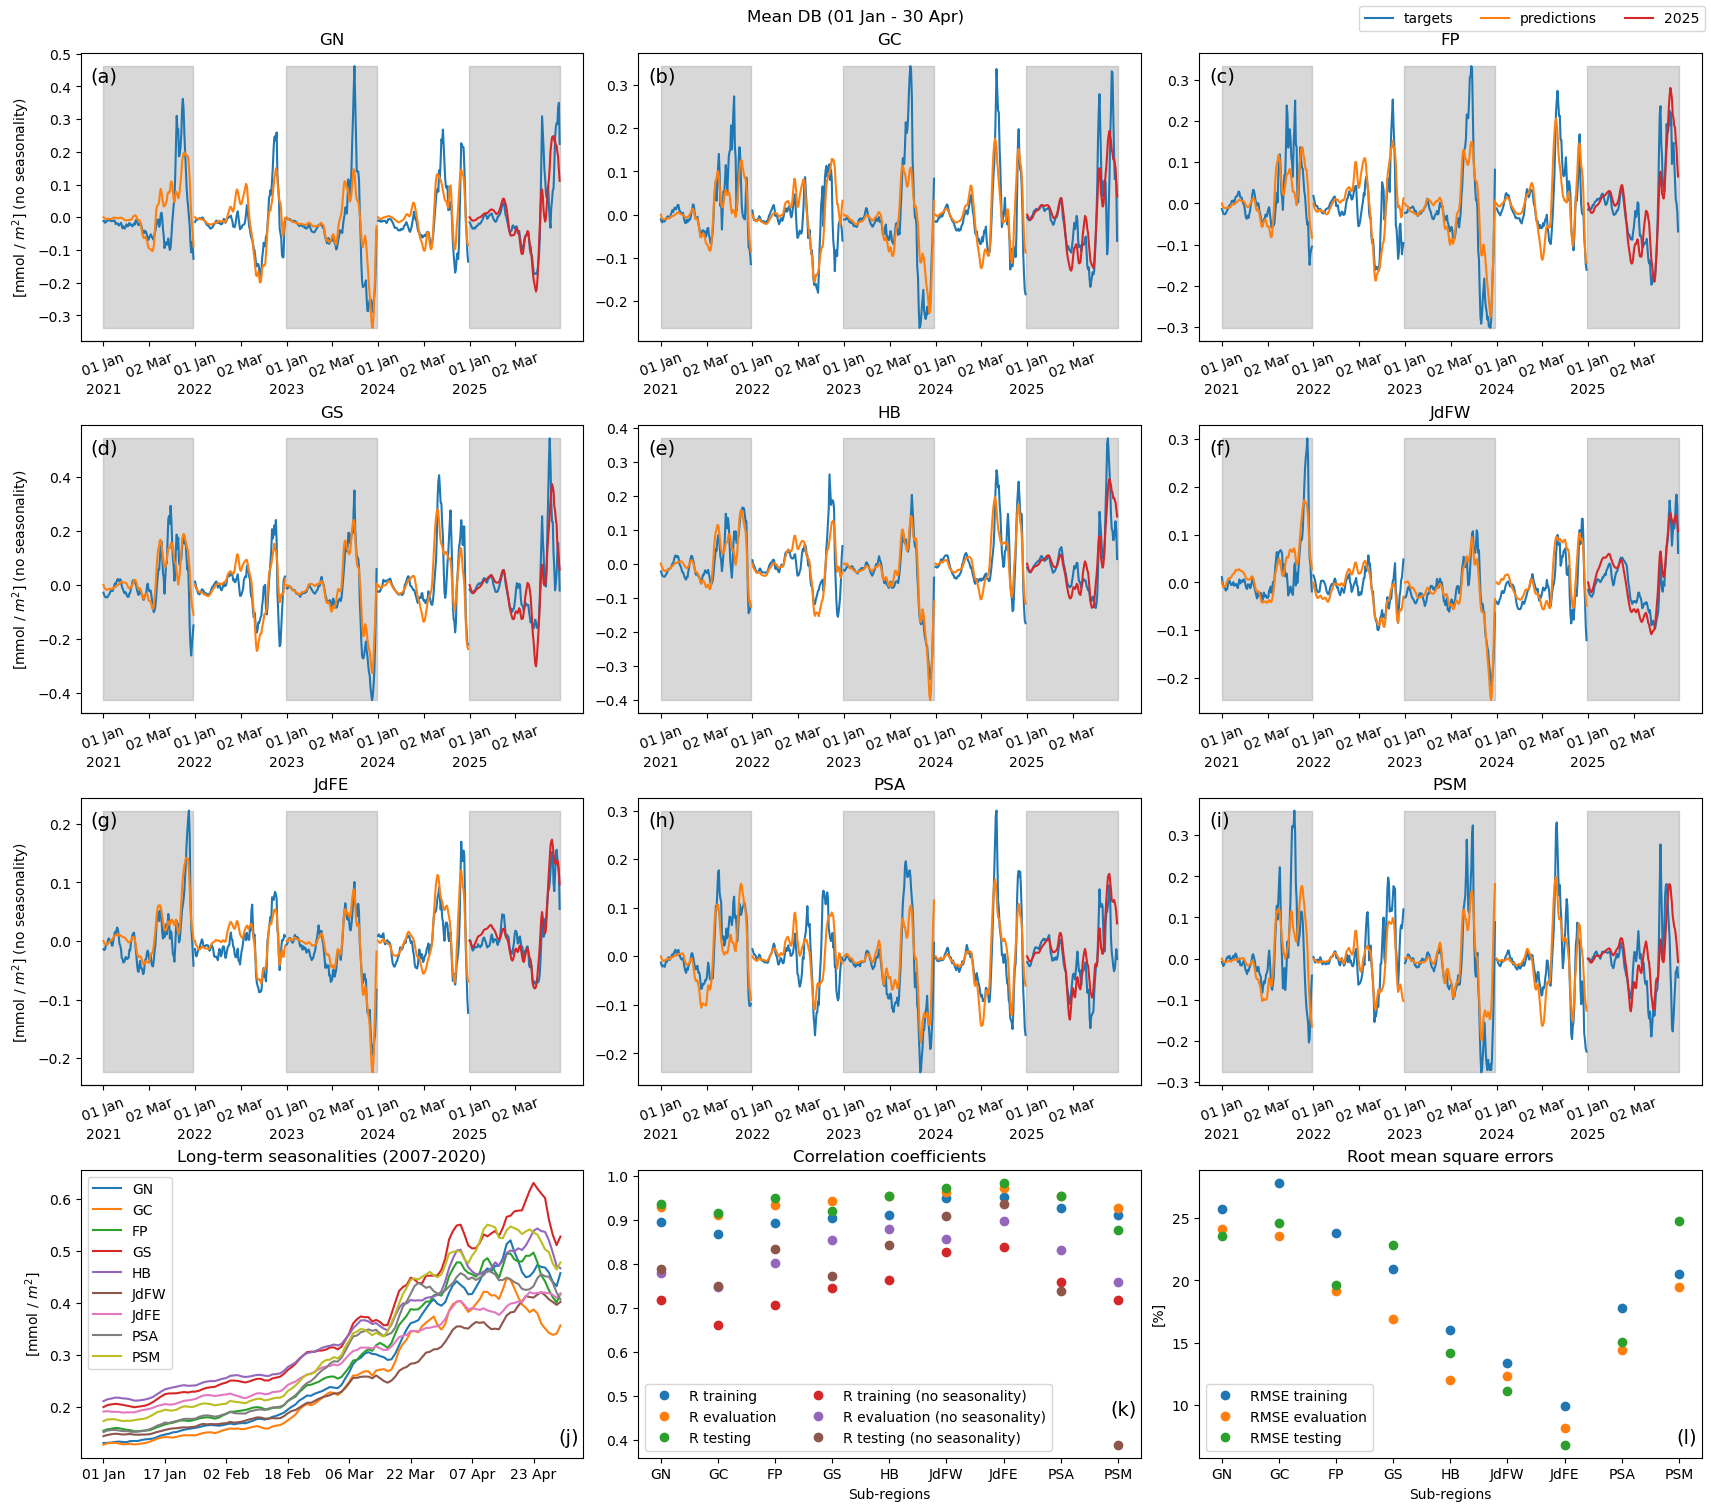

In [22]:
plotting_paper(dates,targets_test-season_test,predictions-season_test,units,boxnames,period,labels,season,r_train,r_train_season,r_test,r_test_season,rms_train,rms_test)

## Saving

In [ ]:
# path = '/data/ibougoudis/MOAD/files/results/' + name + '/single_runs/' + name[0:4].lower() + '_func_reg' + id + '_boxes_s_d1/'

# os.makedirs(path, exist_ok=True)

# with lzma.open(path + 'regr_all.xz', 'wb') as f:   
#     dill.dump(regr_all, f)

# with open(path + 'r_inputs.pkl', 'wb') as f:
#     dill.dump(r_inputs, f)

# with open(path + 'train_metrics.pkl', 'wb') as f:
#     dill.dump([r_train,rms_train,slope_train,r_train_season,slope_train_season,season.transpose()], f)

# with open(path + 'test_metrics.pkl', 'wb') as f:
#     dill.dump([r_test,rms_test,slope_test,r_test_season,slope_test_season,targets_sum,predictions_sum,targets_mean,predictions_mean,targets_diff,predictions_diff,rss], f)

# with open(path + 'targets-predictions.pkl', 'wb') as f:
#     dill.dump([targets_test,predictions], f)

# with open(path + 'readme.txt', 'w') as f:
#     f.write ('name: ' + name)
#     f.write('\n')
#     f.write('period: ' + filename[35:42])
#     f.write ('\n')
#     f.write ('input_features: ')
#     f.write (str([i for i in inputs_names]))
#     f.write ('\n')
#     f.write('n_intervals: ' + str(n_intervals))
#     f.write ('\n')
#     f.write('lags: ')
#     f.write (str([i for i in lags]))
#     f.write ('\n')
